# LGBIO2072:
Simulation for one joint & work on two jointed system
Based on OFC tutorial

In [1]:
import numpy as np
import matplotlib.pyplot as plt
import numpy as np

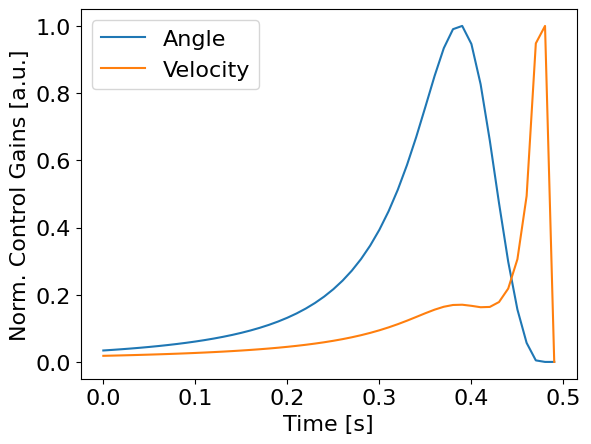

In [2]:
# LQG control for the modelling of a single joint elbow rotation
# Addition: target jump and dependency of the control response on the penalty
# on velocity (undershoot, hit VS stop, see Liu and Todorov, 2007)



# Simulation parameters and model matrices -------------------------------------
# Numerical parameters
G = 0.14      # viscous constant
I = 0.1       # inertia
tau = 0.066   # muscle time constant
delta = 0.01  # Time step

A0 = np.zeros(shape=(3,3))
A0[0,:] = [0,1,0]
A0[1,:] = [0, -G/I, 1/I]
A0[2,:] = [0, 0, -1/tau]

B0 = np.zeros(shape=(3,1))
B0[0] = 0
B0[1] = 0
B0[2] = 1/tau

ns = len(A0)     # dimension of the state vector
nc = len(B0[0])  # dimension of the control vector

# Discrete time
A0 = np.identity(ns)+delta*A0
B0 = delta*B0

# Augmentation of the system matrices to include the target
A = np.zeros(shape=(2*ns,2*ns))
A[0:3,0:3] = A0
A[3:6,3:6] = np.identity(ns)
B = np.zeros(shape=(2*ns,nc))
B[0:3]=B0

# Definition of the cost-function and time -------------------------------------
rtime = 0.5
nStep = int(np.round(rtime/delta))
Q = np.zeros(shape=(nStep+1,2*ns,2*ns))
R = np.zeros(shape=(nStep,nc,nc))

for i in range(nStep):
  R[i,:,:] = 10**-5*np.identity(nc)

w = np.zeros(shape=(1,ns))
w[0,:] = [1,1,0]             # Changing the cost of velocity can be done here

for i in range(ns):
  ei = 0*np.ndarray(shape=(2*ns,1))
  ei[i] = 1
  ei[i+ns] = -1
  Q[nStep,:,:] = Q[nStep,:,:] + w[0,i]*np.matmul(ei,np.transpose(ei))
  Q[nStep-1,:,:] = Q[nStep-1,:,:] + w[0,i]*np.matmul(ei,np.transpose(ei))

# Backward recurrence to calculate the optimal feedback gains ------------------
S=np.zeros(shape=(nStep+1,2*ns,2*ns))                 # Initialisation
S[nStep,:,:] = Q[nStep,:,:]
SigmaXi = 0.05*B@np.transpose(B)                      # Noise covariance matrix
sadd = 0                                              # Offset cost of noise
L = np.zeros(shape=(nStep,nc,2*ns))
gain1 = np.zeros(shape=(nStep,1))
gain2 = np.zeros(shape=(nStep,1))

for i in reversed(range(nStep)):
  # Fill in gain matrix
  p1 = np.matmul(np.transpose(B),S[i+1,:,:])
  den = np.linalg.inv(R[i,:,:]+np.matmul(p1,B))
  L[i,:,:] = den@np.transpose(B)@S[i+1,:,:]@A

  #Update recurrence matrices
  t1 = A-np.matmul(B,L[i,:,:])
  t2 = np.matmul(S[i+1,:,:],t1)
  t3 = np.matmul(np.transpose(A),t2)
  S[i,:,:] = Q[i,:,:]+t3

  # Update the offset cost
  sadd = sadd + np.trace(np.matmul(S[i+1,:,:],SigmaXi))

  #Gain functions to plot
  gain1[i,0]=L[i,0,0]
  gain2[i,0]=L[i,0,1]


#Plotting the control gains
plt.figure(1)
time = np.array(range(50))*delta
plt.plot(time,gain1/np.max(gain1))
plt.yticks(fontsize=16)
plt.xticks(fontsize=16)
plt.plot(time,gain2/np.max(np.abs(gain2)))
plt.xlabel('Time [s]',fontsize=16)
plt.ylabel('Norm. Control Gains [a.u.]',fontsize=16)
plt.legend({'Velocity','Angle'},fontsize=16)

# Question 1:
Implement an stochastic optimal controller for a linear model of two jointed arm with linear muscle

In [ ]:
## Code for a stochastic optimal controller of a linear model of double jointed arm with linear muscle 

# Initial params
deltat = 0.01   # Time step
rtime = 0.5     # simulation time in s

# Given parameters
seg_len1 = 30   # cm
seg_len2 = 33   # cm

seg_mass1 = 1.4 # kg
seg_mass2 = 1   # kg

seg_inertia1 = 0.025    # kgm²
seg_inertia2 = 0.045    # kgm²

d_cent_mass1 = 11   # cm
d_cent_mass2 = 16   # cm


nStep = int(np.round(rtime/delta))



##### Model dynamics ##### 

# Constants:
a1 = seg_inertia1 + seg_inertia2 + seg_mass2 * (seg_len2 **2)
a2 = seg_mass2 * seg_len1 * d_cent_mass2
a3 = seg_inertia2

G_damping = 0.05 ## Guessing???
T_torque_matrix = [[0.5, 0.025],[0.025, 0.5]] ## Guessing this is the b11, b22 0.5 and b21 b 12 0.025

# Theta1= shoulder, Theta2 = elbow

# Model dynamics:
def calc_inertia_matrix(theta2, a1, a2, a3):
    return [a1 + (2 * a2 * np.cos(theta2)), a3 + (a2 * np.cos(theta2))], [ a3 + (a2 * np.cos(theta2)), a3]

def calc_coriolis_matrix(theta2, theta1_dot, theta2_dot, a2):
   return [-theta2_dot * (2 * theta1_dot + theta2_dot) * a2 * np.sin(theta2), theta1_dot**2 * a2 * np.sin(theta2)]

def calc_torque_matrix():
    return None


## Mechanical model:

def calc_theta_dot_dot(theta1, theta2, theta1_dot, theta2_dot, a1, a2, a3, B_damping_matrix, C_coriolis_matrix, M_inertia_matrix, T_torque_matrix):
    return np.linalg.inv(M_inertia_matrix) @ (T_torque_matrix - C_coriolis_matrix - B_damping_matrix @ [theta1_dot, theta2_dot])



# Joint acceleration is the invese of the inertia matrix



# Question 2: 
Simulate reaching movements towards different visual targets

In [ ]:
##

# Question 3: 
Implement visual perturbations

To simulate the target jump, you can modify the following line:

`#target jump` <br>
`if i== (tpert):` <br>
`. . currentState[3] = currentState[3] + (jump)*np.pi/180`

The variable `tpert` is the time of the perturbation (between 1 and 50) and the variable `jump` is the amplitude of the target jump in degrees. To reproduce the restuls of Liu and Todorov (Journal of Neuroscience, 2017) you can modify the time of the perturbation and observe that perturbations that come later produce incomplete corrections.

/tmp/ipykernel_71530/1303293266.py:68: DeprecationWarning: Conversion of an array with ndim > 0 to a scalar is deprecated, and will error in future. Ensure you extract a single element from your array before performing this operation. (Deprecated NumPy 1.25.)
  control[0,i]=u


Text(0, 0.5, 'Control Vector')

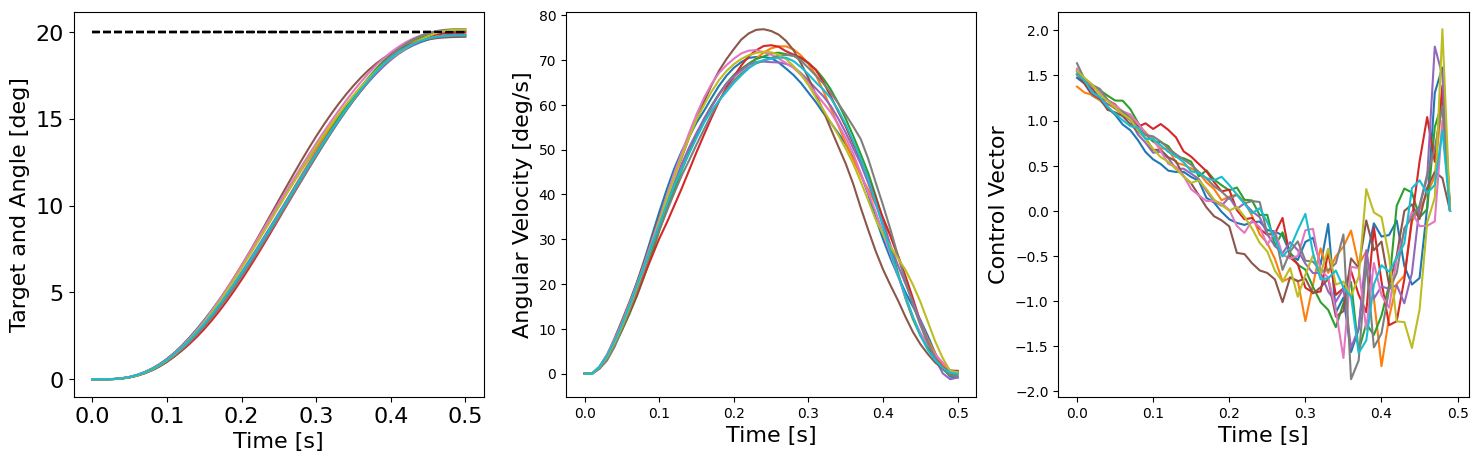

In [3]:
# Forward recurrence -----------------------------------------------------------
# Kalman filter
H = np.identity(2*ns)
ny = len(H)
SigmaOmega = 0.1*np.max(SigmaXi)*np.identity(ny)
SigmaOmega[3,3] = 0.1*np.max(SigmaXi)
Sigma = 0.1*np.max(SigmaXi)*np.identity(ny)
K = np.zeros(shape=(nStep,2*ns,ny))

SigmaXi[3,3] = 0.01*SigmaXi[2,2] # Trick to allow target switches

for i in range(nStep):
  # Computation of gain value
  g1 = np.matmul(Sigma,np.transpose(H))
  g2 = np.matmul(A,g1)
  g3 = np.matmul(H,g1)+SigmaOmega
  K[i,:,:] = np.matmul(g2,np.linalg.inv(g3))

  # Update of Covariance Matrix
  h1 = A-np.matmul(K[i,:,:],H)
  h2 = np.matmul(Sigma,np.transpose(A))
  Sigma = SigmaXi + np.matmul(h1,h2)

SigmaXi[3,3] = 0


# System Dynamics---------------------------------------------------------------
xstate = np.zeros(shape=(nStep+1,2*ns))
xest = np.zeros(shape=(nStep+1,2*ns))
control = np.zeros(shape=(1,nStep))
xstate[0,3] = 20*np.pi/180
xest[0,3] = 20*np.pi/180
nSimu = 10

xmean = np.zeros(shape=(nStep+1,1))
xall = np.zeros(shape=(nStep+1,nSimu))

time1 = np.array(range(51))*delta
fig, (ax1,ax2,ax3) = plt.subplots(1,3,figsize=(18,5))
ax1.tick_params(labelsize=16)

for p in range(nSimu):
  # Variability in initial conditions:
  #xstate[0,:] = np.random.multivariate_normal(np.zeros(ny), SigmaOmega,tol=1e-8)
  xest[0,:] = xest[0,:] + np.random.multivariate_normal(np.zeros(ny), SigmaOmega,tol=1e-8)

  for i in range(nStep):
    currentState = np.transpose(xstate[i,:])

    #target jump
    if i==35:
      currentState[3] = currentState[3] + -0*np.pi/180

    currentEstimate = np.transpose(xest[i,:])

    #u = np.matmul(-L[i,:,:],currentState)
    u = np.matmul(-L[i,:,:],currentEstimate)

    xi = np.random.multivariate_normal(np.zeros(2*ns), SigmaXi ,tol=1e-8)
    omega = np.random.multivariate_normal(np.zeros(ny), SigmaOmega,tol=1e-8)
    y = np.matmul(H,currentState)+omega
    innovation = y-np.matmul(H,currentEstimate)

    nextState = np.matmul(A,currentState) + np.matmul(B,u) + np.transpose(xi)
    nextEstimate = np.matmul(A,currentEstimate) + np.matmul(B,u) + np.matmul(K[i,:,:],innovation)
    xstate[i+1,:] = np.transpose(nextState)
    xest[i+1,:] = np.transpose(nextEstimate)
    control[0,i]=u



  #plt.figure(2)
  ax1.plot(time1,xstate[:,3]*180/np.pi,'k--')
  ax2.plot(time1,xstate[:,1]*180/np.pi)
  ax1.plot(time1,xstate[:,0]*180/np.pi)

  xmean[:,0] += xstate[:,0]/nSimu
  xall[:,p] = xstate[:,0]

  #plt.figure(3)
  ax3.plot(time,np.transpose(control))

ax1.set_xlabel('Time [s]', fontsize=16)
ax1.set_ylabel('Target and Angle [deg]', fontsize=16)


ax2.set_xlabel('Time [s]', fontsize=16)
ax2.set_ylabel('Angular Velocity [deg/s]', fontsize=16)

ax3.set_xlabel('Time [s]', fontsize=16)
ax3.set_ylabel('Control Vector', fontsize=16)



#plt.figure(2)
#plt.figure(3)
#plt.xlabel('Time [s]')
#plt.ylabel('Command Value [Nm]')




The plot below showns the target state and the estimated target state by the Kalman filter. To reproduce the results of Izawa and Shadmehr (Journal of Neuroscience, 2018) you can simulate different levels of noise affecting the sensory signal. This can be done by modifying the line above:
`SigmaOmega = scaling*np.max(SigmaXi)*np.identity(ny)`,

where `scaling` can take different values (try for instance 0.5, 0.1, and 0.05). You will observe that the correction is more vigorous for lower values of the `scaling` parameter, and the estimate of the target state goes faster to the novel value after the target jump.


Text(0, 0.5, 'Terget and Estimate')

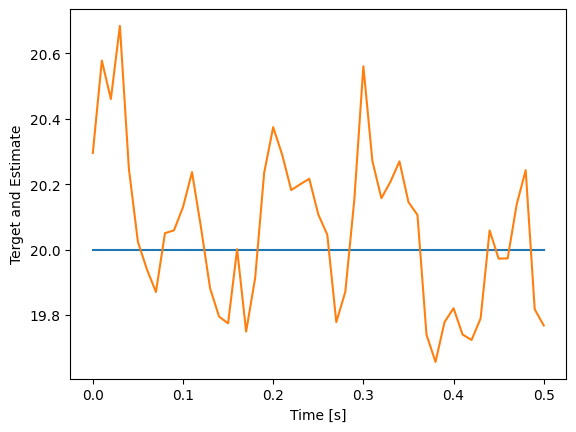

In [4]:
plt.plot(time1,xstate[:,3]*180/np.pi)
plt.plot(time1,xest[:,3]*180/np.pi)
plt.xlabel('Time [s]')
plt.ylabel('Terget and Estimate')


# Question 4: 
Simulate a mechanical perturbation

# Question 5: 
Add delay in the model using the technique of system